# ノイズバジェッティングと多チャンネル相関解析

精密計測（重力波検出器など）において、メインの観測データに含まれる雑音が「何に由来するのか」を特定することは極めて重要です。このプロセスを **Noise Budgeting（ノイズバジェッティング）** と呼びます。

重力波検出器の感度曲線は、低周波では地面振動、中周波では熱雑音、高周波では統計的なノイズ（ショットノイズ）によって制限され、特徴的な「下に凸」の形状を示します。

このチュートリアルでは、以下の流れで解析を実演します。

1.  **多チャンネルデータのシミュレーション**: メインチャンネルに加え、地面振動、磁場変動、回路ノイズなどの補助チャンネルを生成します。
2.  **相関解析 (Coherence Mapping)**: メインチャンネルと各補助チャンネルのコヒーレンスを計算し、主なノイズ源を特定します。
3.  **結合関数の推定 (Transfer Function)**: 補助チャンネルからメインへの「漏れ込み量（伝達関数）」を推定します。
4.  **ノイズ投影 (Noise Projection)**: 伝達関数を用いて、補助チャンネルのノイズをメインチャンネルの単位に変換（投影）します。
5.  **ノイズ予算の可視化 (Noise Budget Plot)**: すべてのノイズ源を重ね合わせ、観測された「U字型」スペクトルの内訳を明らかにします。


In [7]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from gwexpy import TimeSeries, TimeSeriesDict, FrequencySeries

## 1. 多チャンネルデータのシミュレーション (U字型スペクトルの作成)

重力波検出器を模した感度曲線を作成します。
*   `MAIN`: 観測対象。低域で地面振動、高域でアクチュエータ/回路系のノイズが支配的な「下に凸」のスペクトルを持ちます。
*   `AUX_SEIS`: 低周波の地面振動をモニター。
*   `AUX_MAG`: 磁場モニター（60Hzの電源ラインを含む）。
*   `AUX_ELEC`: 高周波側のノイズ源（例：制御システムや読み出し回路のノイズ）。


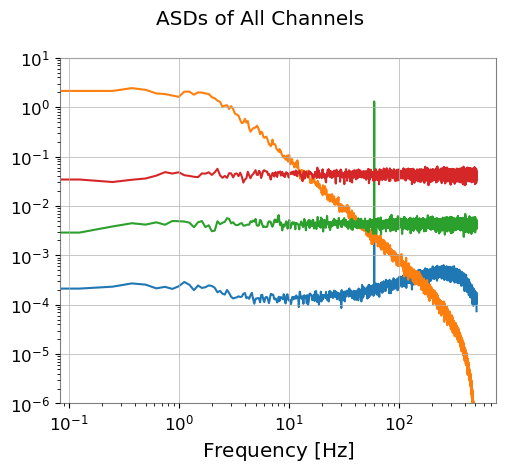

In [8]:
fs = 1024.0
duration = 64.0
t = np.arange(0, duration, 1/fs)
n_samples = len(t)

np.random.seed(42)

# --- 補助チャンネル (Noise Sources) の生成 ---
# 1. 地面振動 (低域支配)
b_low, a_low = signal.butter(2, 2.0, fs=fs, btype='low')
seis_val = signal.lfilter(b_low, a_low, np.random.normal(0, 50.0, n_samples))
seis = TimeSeries(seis_val, sample_rate=fs, name="Seismic", unit="um")

# 2. 磁場 (60Hz + 平坦)
mag_val = np.random.normal(0, 0.1, n_samples)
mag_val += 0.8 * np.sin(2 * np.pi * 60 * t) # 60Hz
mag = TimeSeries(mag_val, sample_rate=fs, name="Magnetic", unit="nT")

# 3. 高域ノイズ源 (回路系)
elec_val = np.random.normal(0, 1.0, n_samples)
elec = TimeSeries(elec_val, sample_rate=fs, name="Electronic", unit="V")

# --- メインチャンネルの生成 (U字型にする) ---
# 基本的なショットノイズ (平坦な底を作る)
main_val = np.random.normal(0, 1e-3, n_samples) *3

# 低域: Seismic の漏れ込み (強め)
main_val += seis.value * 1e-4

# 中域~広帯域: Magnetic の漏れ込み
main_val += mag.value * 2e-3

# 高域: Electronic の漏れ込み (微分処理で f に比例する上昇を作る)
# 周波数特性としての微分は振幅が f に比例する
main_val += np.gradient(elec.value) * 1e-2

main_ch = TimeSeries(main_val, sample_rate=fs, name="Main Channel", unit="strain")

# まとめ
tsd = TimeSeriesDict()
tsd["MAIN"] = main_ch
tsd["AUX_SEIS"] = seis
tsd["AUX_MAG"] = mag
tsd["AUX_ELEC"] = elec

# 全体の ASD を確認
asd_dict = tsd.asd(fftlength=8, method="welch")
asd_dict.plot(xscale="log", yscale="log").suptitle("ASDs of All Channels")
plt.ylim(1e-6, 10)
plt.show()

# MAIN チャンネル（黒色や青色になる想定）が、低域で下がり、
# 高域で上がっていく「下に凸」の形状になっていることが確認できます。


## 2. 相関解析 (Coherence Mapping)

メインチャンネルの「U字」の左側、底、右側で、それぞれどのセンサーと高いコヒーレンスを持っているかを確認します。


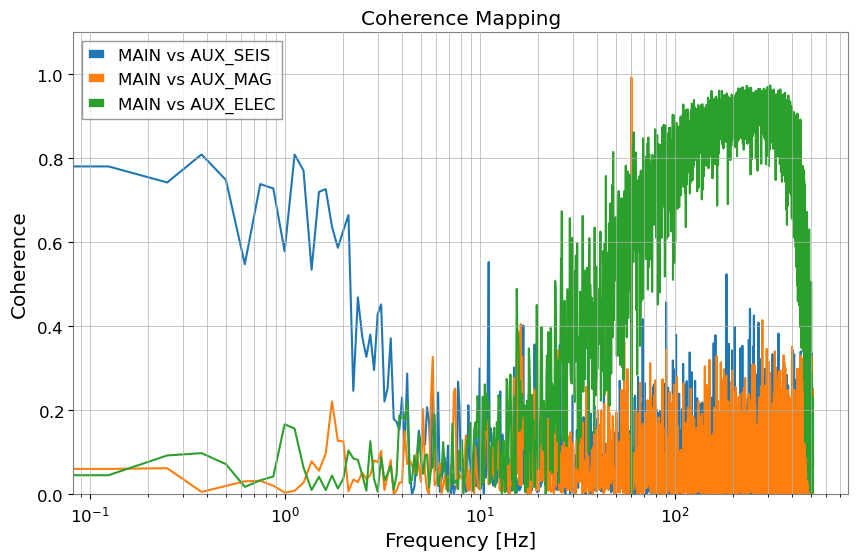

In [9]:
aux_names = ["AUX_SEIS", "AUX_MAG", "AUX_ELEC"]

plt.figure(figsize=(10, 6))
for name in aux_names:
    coh = tsd["MAIN"].coherence(tsd[name], fftlength=8)
    plt.semilogx(coh.frequencies, coh.value, label=f"MAIN vs {name}")

plt.title("Coherence Mapping")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Coherence")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, which="both")
plt.show()

# 低域(10Hz以下)では SEIS、高域(100Hz以上)では ELEC と相関していることが分かります。


## 3. 結合関数の推定

各帯域における漏れ込み係数（伝達関数）を推定します。


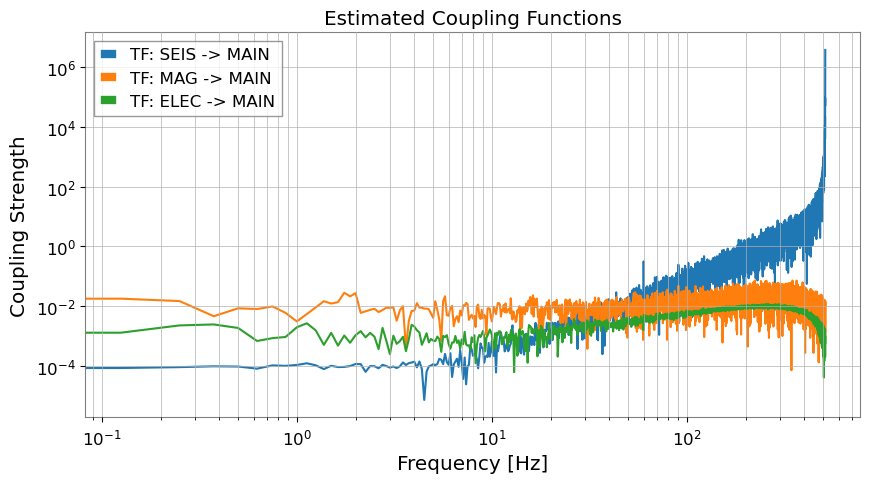

In [10]:
tf_seis = tsd["AUX_SEIS"].transfer_function(tsd["MAIN"], fftlength=8)
tf_mag = tsd["AUX_MAG"].transfer_function(tsd["MAIN"], fftlength=8)
tf_elec = tsd["AUX_ELEC"].transfer_function(tsd["MAIN"], fftlength=8)

plt.figure(figsize=(10, 5))
plt.loglog(tf_seis.frequencies, np.abs(tf_seis.value), label="TF: SEIS -> MAIN")
plt.loglog(tf_mag.frequencies, np.abs(tf_mag.value), label="TF: MAG -> MAIN")
plt.loglog(tf_elec.frequencies, np.abs(tf_elec.value), label="TF: ELEC -> MAIN")

plt.title("Estimated Coupling Functions")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Coupling Strength")
plt.legend()
plt.grid(True, which="both")
plt.show()


## 4. ノイズ投影 (Noise Projection)


In [11]:
proj_seis = asd_dict["AUX_SEIS"] * np.abs(tf_seis.value)
proj_mag = asd_dict["AUX_MAG"] * np.abs(tf_mag.value)
proj_elec = asd_dict["AUX_ELEC"] * np.abs(tf_elec.value)

# 二乗和の平方根で合計寄与を計算
total_proj_val = np.sqrt(proj_seis.value**2 + proj_mag.value**2 + proj_elec.value**2)
total_proj = FrequencySeries(total_proj_val, frequencies=proj_seis.frequencies, unit=main_ch.unit)


## 5. ノイズ予算の可視化 (Noise Budget Plot)

「下に凸」のメインチャンネルのノイズが、どのように解説・分解されるかを表示します。


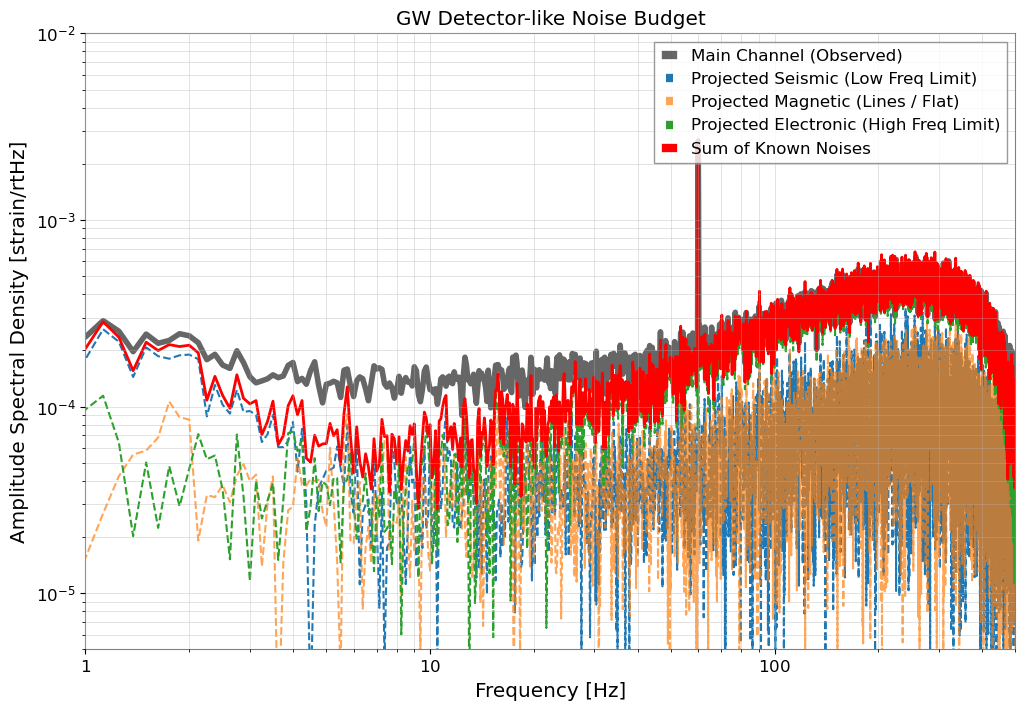

In [12]:
plt.figure(figsize=(12, 8))

# 実際に観測された感度曲線
plt.loglog(asd_dict["MAIN"].frequencies, asd_dict["MAIN"].value, label="Main Channel (Observed)", color="black", linewidth=4, alpha=0.6)

# 各投影成分
plt.loglog(proj_seis.frequencies, proj_seis.value, label="Projected Seismic (Low Freq Limit)", ls="--")
plt.loglog(proj_mag.frequencies, proj_mag.value, label="Projected Magnetic (Lines / Flat)", ls="--", alpha=0.7)
plt.loglog(proj_elec.frequencies, proj_elec.value, label="Projected Electronic (High Freq Limit)", ls="--")

# 合計投影
plt.loglog(total_proj.frequencies, total_proj.value, label="Sum of Known Noises", color="red", linewidth=2)

plt.title("GW Detector-like Noise Budget")
plt.xlabel("Frequency [Hz]")
plt.ylabel(f"Amplitude Spectral Density [{main_ch.unit}/rtHz]")
plt.ylim(5e-6, 1e-2)
plt.xlim(1, 500)
plt.legend(frameon=True, facecolor="white", loc="upper right")
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

# このように、複数のノイズ源が合わさることで、観測される「U字型」の感度曲線が形成されていることが一目で分かります。
